### 图片分类

In [27]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.5.0
sys.version_info(major=3, minor=9, micro=1, releaselevel='final', serial=0)
matplotlib 3.4.2
numpy 1.19.5
sklearn 0.24.2
tensorflow 2.5.0
tensorflow.keras 2.5.0


In [28]:
fashion_mnist = tf.keras.datasets.fashion_mnist
# all:60000, test:10000
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
# 取 5000 张做验证集
# valid:5000, train:55000
x_valid, y_valid = x_train_all[:5000], y_train_all[:5000]
x_train, y_train = x_train_all[5000:], y_train_all[5000:]

print(x_test.shape, y_test.shape)
print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)

(10000, 28, 28) (10000,)
(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)


In [29]:
print(x_train[0], y_train[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   1   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  44 127 182 185 161 120  55
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  42 198 251 255 251 249 247 255 252
  214 100   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   2   0   0 233 252 237 239 234 237 235 237 237
  254 227   0   0   0   0   1   0   0   0]
 [  0   0   0   0   0   2   0   0  16 210 225 215 175 217 216 193 196 226
  221 209  50   0   0   2   0   0   0   0]
 [  0   0   0   0   2   0   0 199 229 232 230 245 204 219 253 245 207 194
  223 231 236 235   0   0   3   0   0   0]
 [  0   0   0   0   1   0 137 235 204 209 201 209 234 190 234 218 215 238
  239 204 189 224 154   0   0   0   0   0]
 [  0   0   0   0   0   0 194 201 200 209 202 193 205 194 183 218 231 197
  172 181 193 205 199   0   0   0   0   0]
 [  0   0   0   0   0   3 212 203 188 189 196 198 198 201 196 21

In [30]:
print(np.max(x_train), np.min(x_train))

255 0


数据归一化处理：x = (x - u) / std

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

In [32]:
print(np.max(x_train_scaled), np.min(x_train_scaled))

2.0231433 -0.8105136


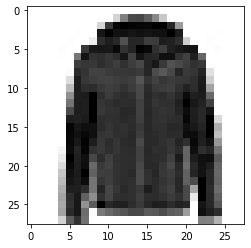

In [33]:
def show_single_image(img_arr):
    # binary 表示 照片黑白
    plt.imshow(img_arr, cmap='binary')

show_single_image(x_train[0])

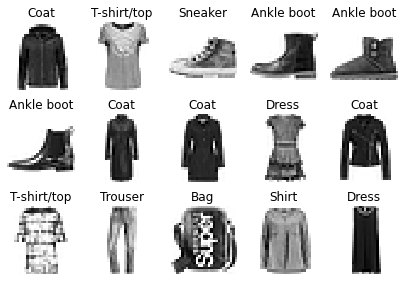

In [34]:
def show_images(rows, cols, x_data, y_data, class_names):
    # 验证
    assert len(x_data) == len(y_data)
    assert rows * cols < len(x_data)
    plt.figure(figsize=(cols * 1.4, rows * 1.6))
    for row in range(rows):
        for col in range(cols):
            # 设置索引
            index = cols * row + col
            plt.subplot(rows, cols, index + 1)
            # interpolation:插值，填充未知像素点
            plt.imshow(x_data[index], cmap="binary", interpolation= 'nearest')
            # axis:坐标轴
            plt.axis('off')
            plt.title(class_names[y_data[index]])
    plt.show()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

show_images(3, 5, x_train, y_train, class_names)

In [35]:
model = tf.keras.models.Sequential()
# 平铺，即二维数组转一维向量
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
# 全连接层，使用relu激活函数(y = max(0, x))
model.add(tf.keras.layers.Dense(128, activation='relu'))
# model.add(tf.keras.layers.Dense(100, activation='relu'))
# 输出单元。多分类问题使用 softmax 单元(将向量变为概率分布)
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# 损失函数(y是索引，所以用sparse)、
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [36]:
# [None, 784] * w(矩阵) + b(偏置) -> [None, 300]
# w.shape=[784, 300], b=[300]
# 235500 = 784 * 300 + 300

Tesorboard(文件夹), earlystopping, ModelCheckpoint(文件)

In [37]:
logdir = './callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "fashion_mnist_model.h5")

callbacks = [
    tf.keras.callbacks.TensorBoard(logdir),
    tf.keras.callbacks.ModelCheckpoint(output_model_file, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(min_delta=1e-3, patience=5)
]

history = model.fit(x_train_scaled, y_train, epochs=10,
                    validation_data = (x_valid_scaled, y_valid),
                    callbacks = callbacks)

Epoch 1/10


2021-08-05 05:38:26.072170: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-08-05 05:38:26.072326: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-08-05 05:38:26.073138: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


   3/1719 [..............................] - ETA: 1:01 - loss: 2.2905 - accuracy: 0.2396

2021-08-05 05:38:26.285604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-05 05:38:26.384608: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-08-05 05:38:26.384617: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-08-05 05:38:26.426501: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-08-05 05:38:26.431662: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-08-05 05:38:26.436924: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./callbacks/train/plugins/profile/2021_08_05_05_38_26
2021-08-05 05:38:26.438159: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./callbacks/train/plugins/profile/2021_08_05_05_38_26/jackydeMacBook.local.trace.json.gz
2021-08-

1719/1719 [==============================] - ETA: 0s - loss: 0.4645 - accuracy: 0.8309  

2021-08-05 05:38:37.793524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 12s 7ms/step - loss: 0.4645 - accuracy: 0.8309 - val_loss: 0.3871 - val_accuracy: 0.8588
Epoch 2/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3548 - accuracy: 0.8698 - val_loss: 0.3502 - val_accuracy: 0.8748

In [38]:
model.evaluate(x_test_scaled, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.3640 - accuracy: 0.8799

[0.3639615774154663, 0.8799000382423401]

In [39]:
history.history

{'loss': [0.4645223617553711,
  0.3547601103782654,
  0.3198500871658325,
  0.2967770993709564,
  0.2778913378715515,
  0.2618196904659271,
  0.24897600710391998,
  0.2362488955259323,
  0.2270864099264145,
  0.21954677999019623],
 'accuracy': [0.8309090733528137,
  0.8697636127471924,
  0.8822908997535706,
  0.8895817995071411,
  0.8972545266151428,
  0.9018545150756836,
  0.9060909152030945,
  0.9114908576011658,
  0.9142545461654663,
  0.9166181683540344],
 'val_loss': [0.38714006543159485,
  0.35020866990089417,
  0.35879576206207275,
  0.33093711733818054,
  0.31900081038475037,
  0.3324158191680908,
  0.3226712942123413,
  0.3310171067714691,
  0.33479923009872437,
  0.34166038036346436],
 'val_accuracy': [0.8588000535964966,
  0.8748000264167786,
  0.8722000122070312,
  0.8820000290870667,
  0.8868000507354736,
  0.8856000304222107,
  0.8886000514030457,
  0.8868000507354736,
  0.8868000507354736,
  0.8868000507354736]}

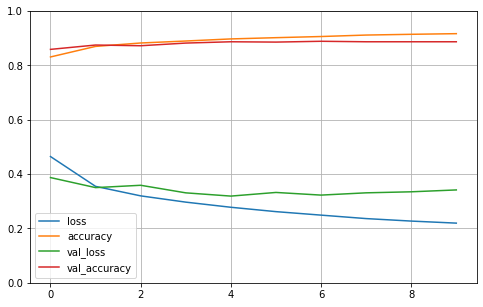

In [40]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)